# Teal Carbon Wetland Scaling Analysis 

Project for UW Geospatial Data Analysis CEE498/CEWA599  
Author: Anthony Stewart 
Start date 2/23/2021


In [58]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
import rioxarray as rxr
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import mapping
import fiona
import scipy.stats as stats
from scipy.linalg import lstsq

# import earthpy as et
# import earthpy.plot as ep

In [59]:
%matplotlib inline

# Use API to grab SRTM 30m/1 Arcsec SRTM DEM tiles for the Hoh

* https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products
* https://apps.nationalmap.gov/downloader/#/ <- this is the map view 
* https://datagateway.nrcs.usda.gov/GDGOrder.aspx <- Data gateway old site

In [60]:
#wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)
#hoh_bounds = (-124.56738280411808 , 47.581065006875235 , -123.81207274552435, 47.92637341837292)
hoh_bounds = (-124.60679627303035,  47.52206972553694, -123.50267029646784, 47.91473130914372)

## Use OpenTopography GlobalDEM API to fetch DEM for WA state
* OpenTopgraphy is a fantastic organization that "facilitates community access to high-resolution, Earth science-oriented, topography data, and related tools and resources."
    * https://opentopography.org/about
* One of the many services they provide is an API for several popular Global DEM datasets, with simple subsetting and delivery: https://opentopography.org/developers
* We'll use this service to extract a small portion of the SRTM-GL3 DEM

In [61]:
#List of all products hosted by OpenTopography GlobalDEM API
demtype_list = ["STMGL3", "SRTMGL1", "SRTMGL1_E", "AW3D30", "AW3D30_E", "SRTM15Plus"]

In [62]:
demtype = demtype_list[1]
demtype

'SRTMGL1'

> This is the 30m DEM

In [63]:
base_url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"

In [64]:
base_url.format(demtype, *hoh_bounds)

'https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&west=-124.60679627303035&south=47.52206972553694&east=-123.50267029646784&north=47.91473130914372&outputFormat=GTiff'

In [65]:
def get_OT_GlobalDEM(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, *bounds) # * unpacks argument one at a time
        print(url)
        #Get
        response = requests.get(url)
        #Should check for 200
        #Write to disk
        open(out_fn, 'wb').write(response.content)

In [66]:
out_fn = f"Hoh_{demtype}.tif"
out_fn
# out_fn_e = f'HohE_{demtype}.tif'

'Hoh_SRTMGL1.tif'

In [67]:
get_OT_GlobalDEM(demtype, hoh_bounds, out_fn)
#get_OT_GlobalDEM(demtype, hoh_e_bounds, out_fn_e)

In [68]:
!ls -lah $out_fn_e

total 51M
drwxrwsr-x  7 jovyan users 4.0K Mar 12 20:35  .
drwxrwsr-x 16 root   users 4.0K Mar 11 04:25  ..
drwxrwsr-x  8 jovyan users 4.0K Mar 12 07:54  .git
drwxrwsr-x  2 jovyan users 4.0K Feb 24 02:04  .ipynb_checkpoints
-rw-rw-r--  1 jovyan users  72K Feb 22 23:59 'First Model.JPG'
-rw-rw-r--  1 jovyan users 6.3M Mar 12 04:18  Hoh_SRTMGL1.tif
-rw-rw-r--  1 jovyan users 2.3K Feb 24 02:03  README.md
-rw-rw-r--  1 jovyan users 268K Feb 22 23:18  carbonstockplot.jpeg
-rw-rw-r--  1 jovyan users  296 Feb 24 03:08  hoh_Cstock_pts.shp
-rw-rw-r--  1 jovyan users 1.7M Mar 12 05:35  hoh_WIP.tif
-rw-rw-r--  1 jovyan users  32M Mar 10 06:42  hoh_clip.tif
-rw-rw-r--  1 jovyan users  554 Mar  2 05:55  hoh_sample_datasheet_2020.csv
-rw-rw-r--  1 jovyan users  12K Feb 24 03:08  hoh_sample_datasheet_2020.xlsx
drwxrwsr-x  2 jovyan users 4.0K Mar  2 06:15  hoh_shape
drwxrwsr-x  2 jovyan users 4.0K Mar  9 18:00  hoh_watershed_outline
-rw-rw-r--  1 jovyan users 2.8M Feb 24 02:09  rclip_SCatA.tif
-rw-rw-r

In [69]:
!gdalinfo $out_fn

Driver: GTiff/GeoTIFF
Files: Hoh_SRTMGL1.tif
Size is 3975, 1414
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-124.606805555548220,47.914861111109509)
Pixel Size = (0.000277777777778,-0.000277777777778)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
  LAYOUT=COG
Corner Coordinates:
Upper Left  (-124.6068056,  47.9148611) (124d36'24.50"W, 47d54'53.50"N)
Lower Left  (-124.6068056,  47.5220833) (124d36'24.50"W, 47d31'19.50"N)


Open the raster file with rasterio

In [70]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

In [71]:
hoh_src = rio.open(out_fn)
hoh = hoh_src.read(1, masked =True)
#hoh = rxr.open_rasterio(out_fn_e, masked=True).squeeze()
hoh


masked_array(
  data=[[1, 2, 2, ..., 483, 478, 473],
        [-1, 1, 1, ..., 496, 492, 488],
        [-3, -1, 1, ..., 505, 501, 497],
        ...,
        [0, 0, 0, ..., 877, 879, 880],
        [0, 0, 0, ..., 878, 876, 874],
        [0, 0, 0, ..., 878, 872, 867]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-32768,
  dtype=int16)

# Import in raster files for all metrics and the model output

[Text(0.5, 1.0, 'Hoh SRTM DEM')]

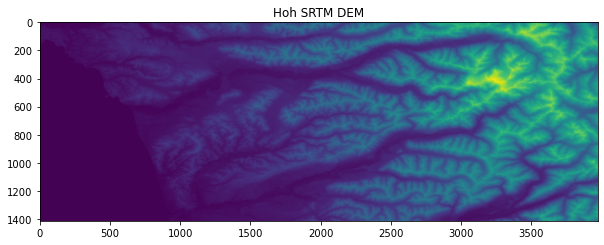

In [72]:
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow(hoh)
ax.set(title="Hoh SRTM DEM")

# Find and grab shapefile for the Hoh to use for clipping

In [73]:
#For now...
hoh_shp_fn = '../gda_teal_carbon/hoh_watershed_outline/hoh_watershed_outline.shp'
hoh_shp = gpd.read_file(hoh_shp_fn)
hoh_geom = hoh_shp.geometry
type(hoh_geom)

geopandas.geoseries.GeoSeries

Reproject to EPSG:4326

<AxesSubplot:>

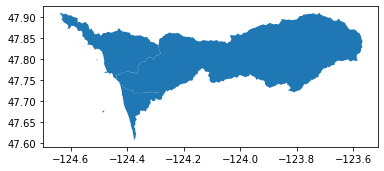

In [74]:
hoh_geom = hoh_geom.to_crs('EPSG:4326')
hoh_geom.plot()

-124.56738280411808 	  Ymin = 47.581065006875235 	  Xmax = -123.81207274552435 	  Ymax = 47.92637341837292# Need to merge SRTM DEMs together

# Clip the DEMs and other rasters by the Hoh shapefile

In [75]:
hoh_clip, hoh_clip_trans = rio.mask.mask(hoh_src, hoh_geom, filled = False, crop = True, indexes = 1)
hoh_clip_extent = rio.plot.plotting_extent(hoh_clip, hoh_clip_trans)


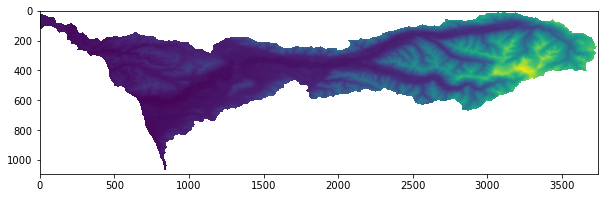

In [76]:
f,ax = plt.subplots(figsize = (10,5))
ax.imshow(hoh_clip)


In [77]:
# hoh_clipped = hoh.rio.clip(hoh_geom.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       hoh_geom.crs)
# cat_clipped = catarea.rio.clip(hoh_geom.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       hoh_geom.crs)
# twi_clipped = twi.rio.clip(hoh_geom.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       hoh_geom.crs)
# slp_clipped = slp.rio.clip(hoh_geom.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       hoh_geom.crs)

## Export raster for Hoh

In [78]:
data_path = '../gda_teal_carbon/'
hoh_clip_path = 'hoh_clip.tif'
hoh_clip_data_path = os.path.join(data_path, hoh_clip_path)
if os.path.exists(hoh_clip_data_path):
    print("The directory", hoh_clip_data_path, "exists!")
else:
    hoh_clipped.rio.to_raster(hoh_clip_data_path)

The directory ../gda_teal_carbon/hoh_clip.tif exists!


# This might be where ArcGIS is needed to generate DEM metrics (slope, catchment, curvature, etc.) and to get the model output

        ## whooo magic!


# Import raster outputs from ArcGIS 

In [79]:
wip_fn = 'hoh_WIP.tif'
wip_src = rio.open(wip_fn, masked=True)
wip = wip_src.read(1, masked = True)
#wip = rxr.open_rasterio(wip_fn, masked=True).squeeze()
wip_src.crs

CRS.from_epsg(26910)

In [80]:
slp_fn = 'rclip_TWISlope.tif'
slp_src = rio.open(slp_fn, masked=True)
slp = slp_src.read(1, masked = True)
#slp = rxr.open_rasterio(slp_fn, masked=True).squeeze()
slp

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [81]:
twi_fn = 'rclip_TWI.tif'
twi_src = rio.open(twi_fn)
twi = twi_src.read(1, masked = True)
#twi = rxr.open_rasterio(twi_fn, masked=True).squeeze()
twi

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [82]:
catarea_fn = 'rclip_SCatA.tif'
catarea_src = rio.open(catarea_fn)
#catarea_src_epsg = catarea_src.to_crs('EPSG:4326')
catarea = catarea_src.read(1, masked = True)
#catarea = rxr.open_rasterio(catarea_fn, masked=True).squeeze()
catarea

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [83]:
# dst_crs = 'EPSG:26910'
# hoh_geom_reproj = rio_reproj_write(catarea_src, )
# cat_clip, cat_clip_trans = rio.mask.mask(catarea_src, hoh_geom_reproj, filled = False, crop = True, indexes = 1)

# twi_clip, twi_clip_trans = rio.mask.mask(twi_src, hoh_geom, filled = False, crop = True, indexes = 1)

# slp_clip, slp_clip_trans = rio.mask.mask(slp_src, hoh_geom, filled = False, crop = True, indexes = 1)



[Text(0.5, 1.0, 'Raster Layer Cropped to Geodataframe Extent')]

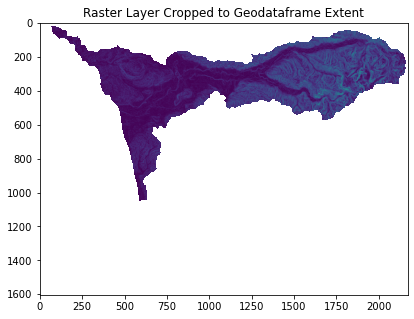

In [84]:
f, ax = plt.subplots(figsize = (10, 5))
ax.imshow(slp)

ax.set(title="Raster Layer Cropped to Geodataframe Extent")


# Make a raster stack

# Import the point data for the Carbon Stocks

In [85]:
hohpts_fn = '../gda_teal_carbon/hoh_sample_datasheet_2020.csv'
hohpts_df = pd.read_csv(hohpts_fn)
hohpts_gdf = gpd.GeoDataFrame(hohpts_df, crs='EPSG:4310', geometry=gpd.points_from_xy(hohpts_df['lon'], hohpts_df['lat']))
hoh_pts = hohpts_gdf.to_crs(catarea_src.crs)
hohpts_geo = gpd.read_file(hohpts_fn)
hoh_pts

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,sample name,c_stock_g_cm2,full_horiz_c_stock,WIP,w_or_u,lat,lon,geometry
0,W Hoh Oxbow,0.057251,0.928835,0.855,w,47.810750,-124.260700,POINT (405614.756 5296035.660)
1,E-ML-FR-H-1040,0.530333,6.987945,0.075,w,47.778390,-124.116967,POINT (416323.580 5292273.720)
2,Hoh-ML-FR-1008.1,0.918214,4.041169,0.105,u,47.797501,-124.188779,POINT (410976.575 5294477.878)
3,Hoh-ML-NE-FR-1043,2.967889,7.803837,0.270,w,47.787200,-124.110355,POINT (416832.959 5293245.729)
4,S-Hoh-ML-FR-1200,0.645896,1.289509,0.365,u,47.789367,-124.166635,POINT (412621.201 5293548.615)
5,N-Up-Hoh-MC,0.110212,1.767975,0.755,u,47.821061,-124.042698,POINT (421951.246 5296938.521)
6,N-Mid-Hoh-MC,0.034643,1.191331,0.010,w,47.813808,-124.129756,POINT (415423.020 5296223.982)


# Extract data from the around the point data 
* Look at Friedrich's links in Slack
* Try different methods of extraction (Nearest Neighbor, etc.)

Overlay points on top of raster

<AxesSubplot:>

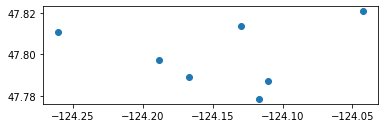

In [86]:
f, ax = plt.subplots()
hohpts_gdf.plot(ax =ax)


In [87]:
coord_list =[(x,y) for x,y in zip(hoh_pts.geometry.x , hoh_pts.geometry.y)]

wip_sample = rio.sample.sample_gen(wip_src, coord_list)
wip_sample_wrap = np.fromiter(wip_sample, float)

catarea_sample = rio.sample.sample_gen(catarea_src, coord_list)
catarea_sample_wrap = np.fromiter(catarea_sample, float)

twi_sample = rio.sample.sample_gen(twi_src, coord_list)
twi_sample_wrap = np.fromiter(twi_sample, float)

slp_sample = rio.sample.sample_gen(slp_src, coord_list)
slp_sample_wrap = np.fromiter(slp_sample, float)

In [88]:
slp_sample_wrap

array([0.26400793, 0.03252063, 0.03422566, 0.05912117, 0.06644697,
       0.11733727, 0.07163873])

In [89]:
1-wip_sample_wrap

array([0.19499999, 0.69      , 0.61000001, 0.45999998, 0.685     ,
       0.48000002, 0.32499999])

In [90]:
#hoh_pts.drop(['wip_smpl'], axis = 1)
hoh_pts['wip_smpl'] = 1 - wip_sample_wrap
hoh_pts['catarea_smpl'] = catarea_sample_wrap
hoh_pts['twi_smpl'] = twi_sample_wrap
hoh_pts['slp_smpl'] = slp_sample_wrap

In [91]:
hoh_pts

,sample name,c_stock_g_cm2,full_horiz_c_stock,WIP,w_or_u,lat,lon,geometry,wip_smpl,catarea_smpl,twi_smpl,slp_smpl
0,W Hoh Oxbow,0.057251,0.928835,0.855,w,47.810750,-124.260700,POINT (405614.756 5296035.660),0.195,77.952316,5.687873,0.264008
1,E-ML-FR-H-1040,0.530333,6.987945,0.075,w,47.778390,-124.116967,POINT (416323.580 5292273.720),0.690,820.577393,10.135889,0.032521
2,Hoh-ML-FR-1008.1,0.918214,4.041169,0.105,u,47.797501,-124.188779,POINT (410976.575 5294477.878),0.610,639.565857,9.835569,0.034226
3,Hoh-ML-NE-FR-1043,2.967889,7.803837,0.270,w,47.787200,-124.110355,POINT (416832.959 5293245.729),0.460,128.276794,7.682357,0.059121
4,S-Hoh-ML-FR-1200,0.645896,1.289509,0.365,u,47.789367,-124.166635,POINT (412621.201 5293548.615),0.685,59.830788,6.802872,0.066447
5,N-Up-Hoh-MC,0.110212,1.767975,0.755,u,47.821061,-124.042698,POINT (421951.246 5296938.521),0.480,425.741943,8.196536,0.117337
6,N-Mid-Hoh-MC,0.034643,1.191331,0.010,w,47.813808,-124.129756,POINT (415423.020 5296223.982),0.325,37.621521,6.263696,0.071639


# Regression between carbon values and raster values

In [92]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(hoh_pts['full_horiz_c_stock'] , hoh_pts['wip_smpl'])

In [93]:
print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))
print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 0.4003
B1 : 0.0268
R^2 : 0.175
R : 0.419
stderr : 0.026


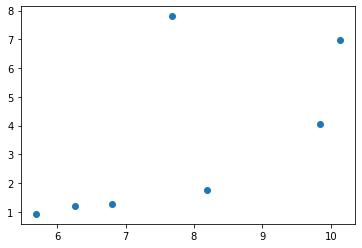

In [94]:
f, ax = plt.subplots()

ax.scatter(hoh_pts['twi_smpl'], hoh_pts['full_horiz_c_stock'])

In [95]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(hoh_pts['full_horiz_c_stock'] , hoh_pts['wip_smpl'])

In [96]:
print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))
print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 0.4003
B1 : 0.0268
R^2 : 0.175
R : 0.419
stderr : 0.026


In [97]:
multi_input = np.array([hoh_pts['wip_smpl'], hoh_pts['catarea_smpl'], 
                        hoh_pts['twi_smpl'], hoh_pts['slp_smpl'], np.ones_like(hoh_pts['wip_smpl'])]).T
B, _, _, _ = lstsq(multi_input, hoh_pts['full_horiz_c_stock'])
print('wip, catarea, twi, slp = {}'.format(np.round(B, 3)))

wip, catarea, twi, slp = [-5.6200e+00 -1.5000e-02  4.2590e+00  4.4140e+00 -2.2833e+01]


In [98]:
MLR = B[0]*hoh_pts['wip_smpl'] + B[1]*hoh_pts['catarea_smpl'] + B[2]*hoh_pts['twi_smpl'] + B[3]*hoh_pts['slp_smpl'] + B[4]

In [102]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(hoh_pts['full_horiz_c_stock'] , MLR)

In [106]:
#hoh_stack = np.dstack((B[1]*catarea, B[2]*twi, B[3]*slp, B[0]*wip))
hoh_stack = np.dstack((catarea, twi, slp, wip))

In [107]:
hoh_stack[1]

masked_array(
  data=[[-3.402823e+38, -3.402823e+38, -3.402823e+38, -3.400000e+38],
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, -3.400000e+38],
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, -3.400000e+38],
        ...,
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, -3.400000e+38],
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, -3.400000e+38],
        [-3.402823e+38, -3.402823e+38, -3.402823e+38, -3.400000e+38]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


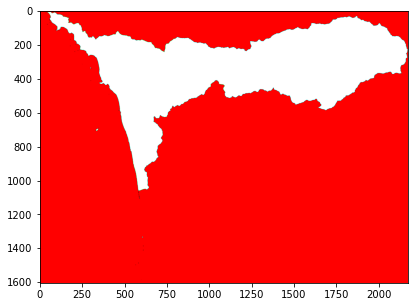

In [101]:
f, ax = plt.subplots(figsize = (10, 5))
ax.imshow(hoh_stack)